In [1]:
# Authors: Samantha Tetef and Vikram Kashyap
# Date: Winter 2020-2021 to Summer 2021

In [2]:
import warnings
warnings.filterwarnings("ignore")

import utils as u
from importlib import reload
# to reload utils, run:
# u = reload(u)

import os
import copy
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
import mplcursors
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from pathlib import Path
from collections import defaultdict

import webbrowser

warnings.filterwarnings("ignore")

In [3]:
u = reload(u)

In [4]:
%matplotlib notebook

In [5]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
   return false;
}

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


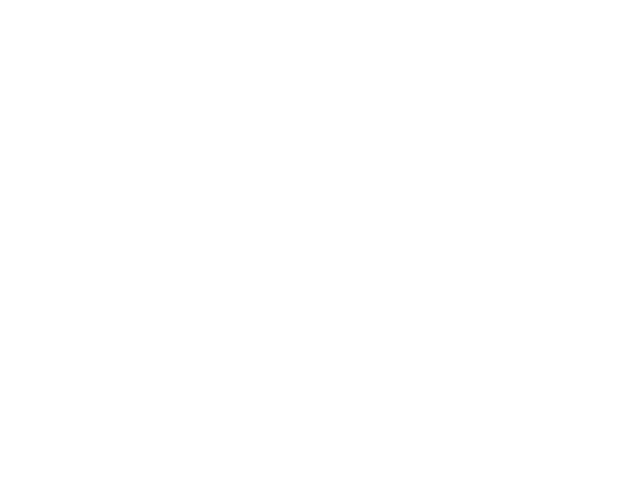

In [6]:
plt.gcf().subplots_adjust(bottom=0.15)

In [31]:
ROOTDIR = Path()

DataDir = ROOTDIR/"ProcessedData"
ListDir = ROOTDIR/"Categories"

XES_data = u.get_Data(ListDir, mode='xes')
XANES_data = u.get_Data(ListDir, mode='xanes')

In [8]:
XESenergies = XES_data[0]['Spectra'][0]
XANESenergies = XANES_data[0]['Spectra'][0]

In [9]:
len(XES_data)

563

# ML and Data Science section

In [10]:
typecodes = {'other':0,
             'tetralkyl_phosphonium':1,
             'trialkyl_phosphines':2,
             'phosphine_oxides':3,
             'phosphinate':4,
             'phosphenic_acids':5,
             'phosphite_esters':6,
             'phosphonate':7,
             'phosphonic_acids':8,
             'phosphate_esters':9,
             }

typecodemap = {compound['CID']:typecodes[compound['Type']] for compound in XANES_data}
colormap_bytype = {compound['CID']:u.colorbynumber(typecodemap[compound['CID']]) for compound in XANES_data}

<IPython.core.display.Javascript object>


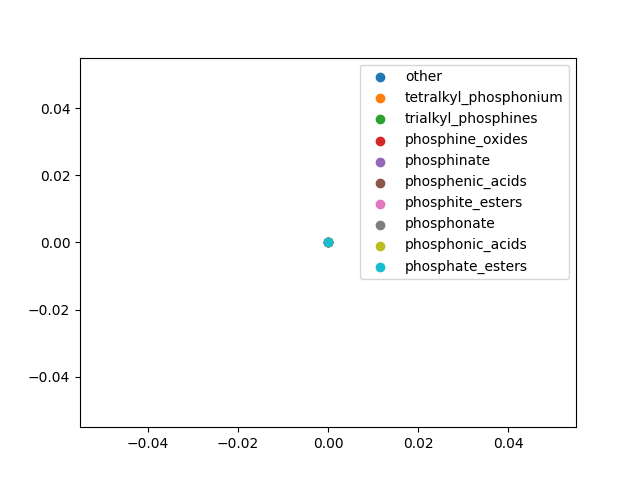

In [11]:
plt.figure()
for t in typecodes:
    plt.scatter(0,0,label=t)
plt.legend()

## All Spectra Together

<IPython.core.display.Javascript object>


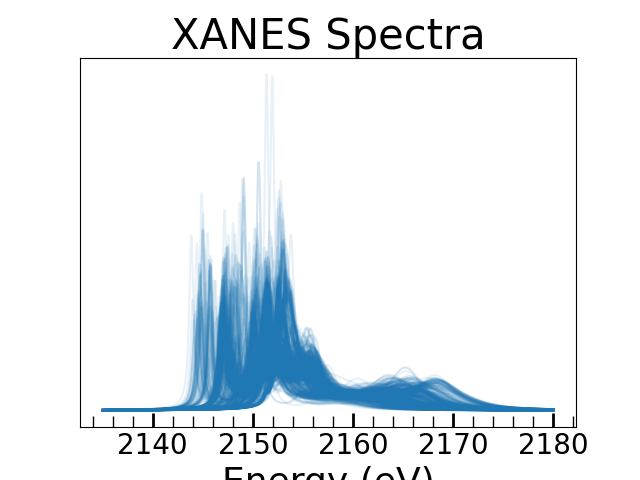

<IPython.core.display.Javascript object>


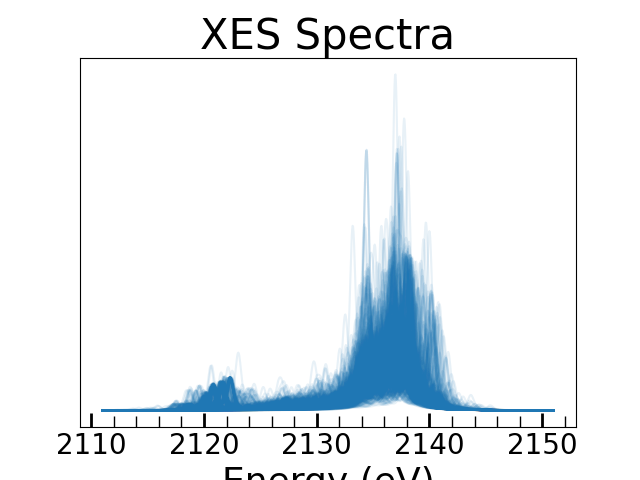

In [32]:
xanesplot = u.plot_spaghetti(plt.subplots(), XANES_data, mode='XANES', coloralpha=0.1);
u.plot_spaghetti(plt.subplots(), XES_data, mode='XES', coloralpha=0.1);

u.add_pubchem_link(xanesplot, XANES_data)

## Rainbow Spaghetti Plot: Color by Compound Type

<IPython.core.display.Javascript object>


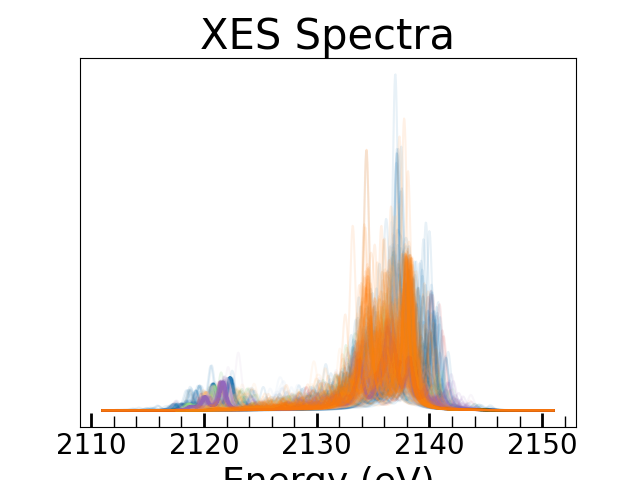

In [13]:
u.plot_spaghetti(plt.subplots(), XES_data, colormap=typecodemap, mode='XES', coloralpha=0.1);

## Rainbow Spaghetti Plot: Color and Stack by Compound Type

<IPython.core.display.Javascript object>


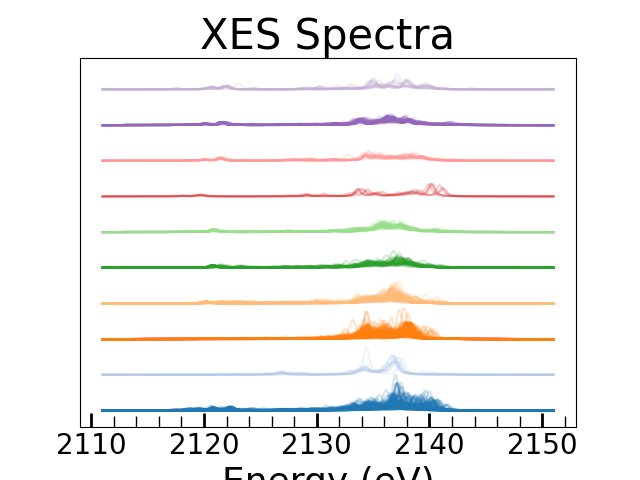

<IPython.core.display.Javascript object>


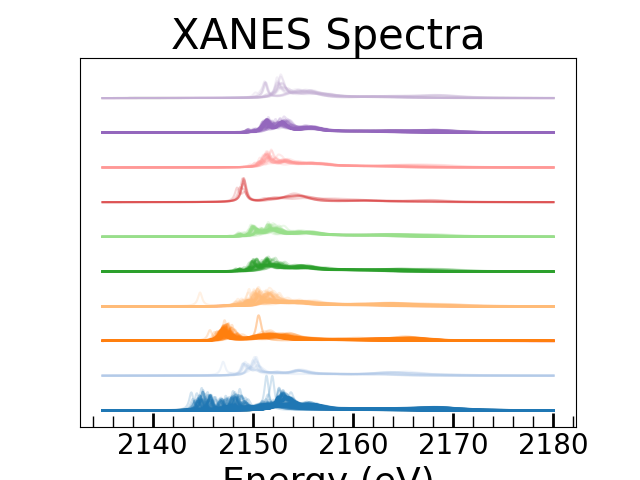

In [14]:
xes_stackplot = u.plot_spaghetti(plt.subplots(), XES_data, \
        colormap=typecodemap, binmap=typecodemap, mode='XES', coloralpha=0.2);
xanes_stackplot = u.plot_spaghetti(plt.subplots(), XANES_data, \
        colormap=typecodemap, binmap=typecodemap, mode='XANES', coloralpha=0.2);

#u.add_label(xes_stackplot, XES_data)
u.add_pubchem_link(xanes_stackplot, XANES_data)

## ML Reduced Space: PCA and T-SNE

In [15]:
warnings.filterwarnings("ignore")

XES = [compound['Normalized'] for compound in XES_data]
XANES = [compound['Normalized'] for compound in XANES_data]

# pca
pca1 = PCA(n_components=10)
XES_PCA = pca1.fit_transform(XES)

# pca
pca2 = PCA(n_components=10)
XANES_PCA = pca2.fit_transform(XANES)

# tsne
tsne = TSNE(n_components=2, perplexity=20)
XES_TSNE = tsne.fit_transform(XES)

# tsne
tsne = TSNE(n_components=2, perplexity=20, random_state=30)
XANES_TSNE = tsne.fit_transform(XANES)


# Make CID->point maps
XANES_tsnemap = {compound['CID']:point for compound,point in zip(XANES_data, XANES_TSNE)}
XES_tsnemap = {compound['CID']:point for compound,point in zip(XES_data, XES_TSNE)}

<IPython.core.display.Javascript object>


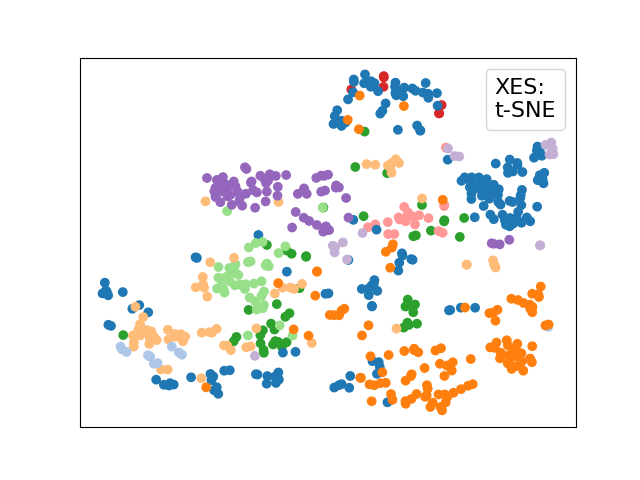

<IPython.core.display.Javascript object>


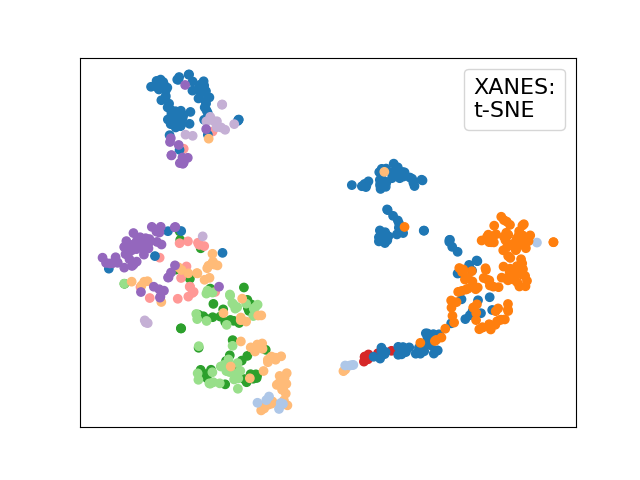

In [16]:
xesplot = u.plot_dim_red(plt.subplots(), XES_data, XES_tsnemap, typecodemap, mode='XES', method='t-SNE')
xanesplot = u.plot_dim_red(plt.subplots(), XANES_data, XANES_tsnemap, typecodemap, mode='XANES', method='t-SNE')

u.add_label(xesplot, XES_data)
u.add_label(xanesplot, XANES_data)

## Reduced Space: Algorithmic Clustering

In [17]:
# Uncomment and run the line below to stop it linking to PubChem when you click on the figures
linktopubchem = False

In [18]:
from sklearn.cluster import DBSCAN

In [19]:
XANES_clustering = DBSCAN(eps=2.5, min_samples=1).fit(XANES_TSNE)
XANES_clustermap = {compound['CID']:cluster for compound,cluster in zip(XANES_data, XANES_clustering.labels_)}

XES_clustering = DBSCAN(eps=2.5, min_samples=1).fit(XES_TSNE)
XES_clustermap = {compound['CID']:cluster for compound,cluster in zip(XES_data, XES_clustering.labels_)}

In [20]:
len(set(XANES_clustering.labels_))

18

<IPython.core.display.Javascript object>


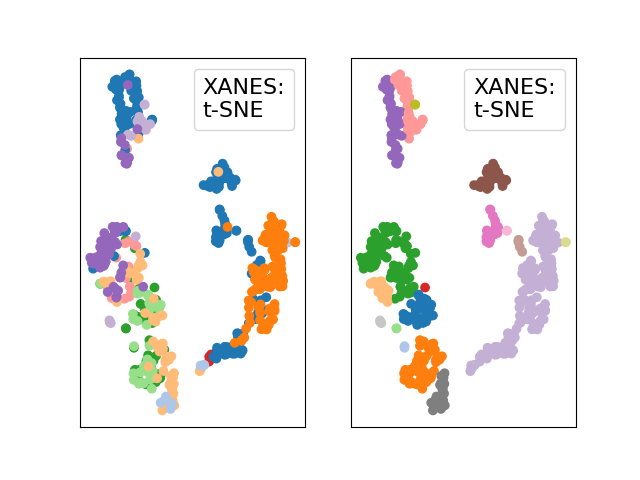

In [21]:
fig, axes = plt.subplots(1,2)
subplots = [(fig, ax) for ax in axes]

redspace_dots_clustered = u.plot_dim_red(subplots[0], XANES_data, XANES_tsnemap, typecodemap, mode='XANES')

redspace_dots_categorized = u.plot_dim_red(subplots[1], XANES_data, XANES_tsnemap, XANES_clustermap, mode='XANES')

<IPython.core.display.Javascript object>


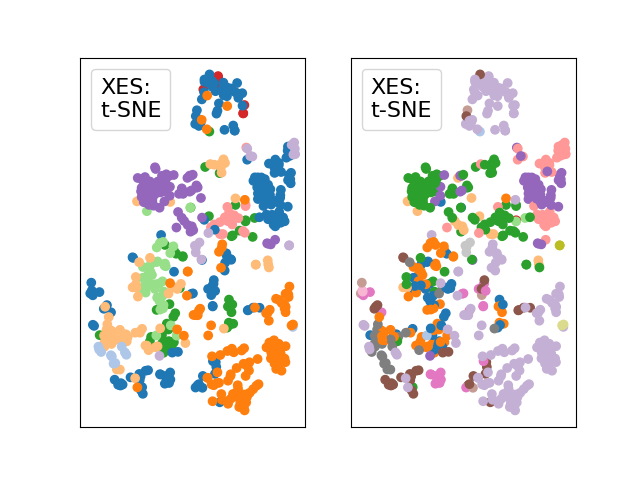

In [22]:
fig, axes = plt.subplots(1,2)
subplots = [(fig, ax) for ax in axes]

redspace_dots_clustered = u.plot_dim_red(subplots[0], XES_data, XES_tsnemap, typecodemap, mode='XES')

redspace_dots_categorized = u.plot_dim_red(subplots[1], XES_data, XES_tsnemap, XANES_clustermap, mode='XES')

<IPython.core.display.Javascript object>


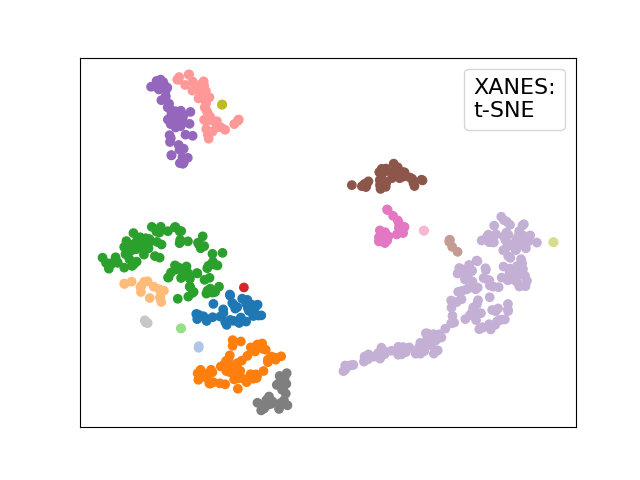

In [23]:
redspace_dots_categorized = u.plot_dim_red(plt.subplots(), XANES_data, XANES_tsnemap, XANES_clustermap, mode='XANES')

## Download Structure Diagrams

## Compare Clusters within Type

<IPython.core.display.Javascript object>


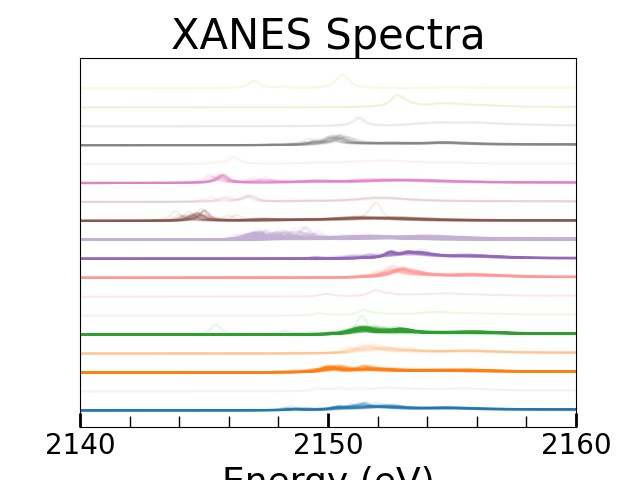

In [24]:
u.plot_spaghetti(plt.subplots(), XANES_data, binmap=XANES_clustermap, colormap=XANES_clustermap, mode='XANES', coloralpha=0.1, energyrange=[2140,2160]);

<IPython.core.display.Javascript object>


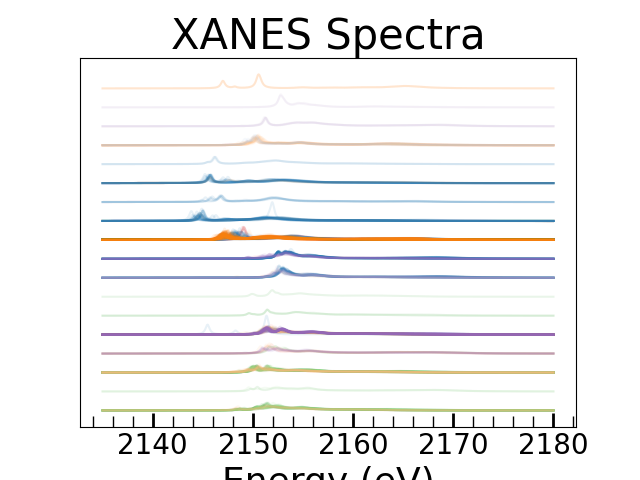

In [25]:
u.plot_spaghetti(plt.subplots(), XANES_data, binmap=XANES_clustermap, colormap=typecodemap, mode='XANES', coloralpha=0.1);

<IPython.core.display.Javascript object>


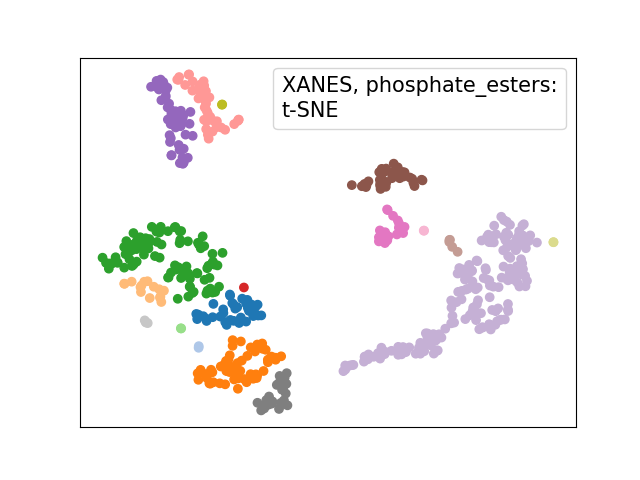

In [26]:
plot = u.plot_dim_red(plt.subplots(), XANES_data, XANES_tsnemap, colormap=XANES_clustermap, mode=f'XANES, {t}', fontsize=15)
u.add_pubchem_link(plot, XANES_data)
u.add_label(plot, XANES_data, XANES_clustermap)

<IPython.core.display.Javascript object>


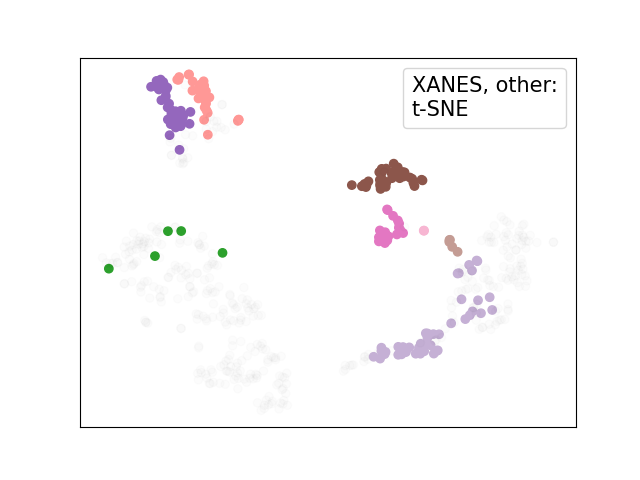

<IPython.core.display.Javascript object>


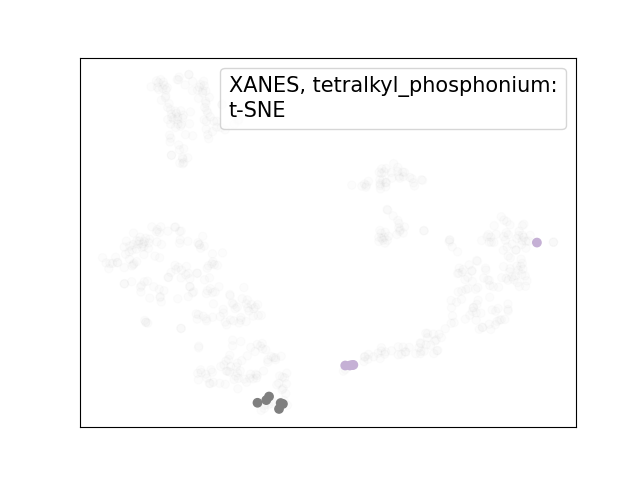

<IPython.core.display.Javascript object>


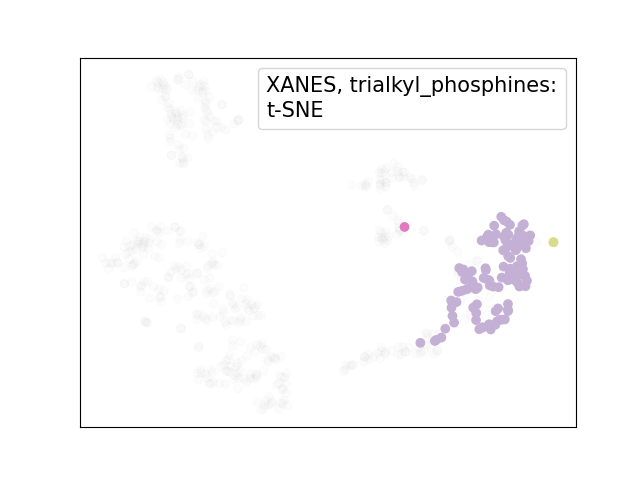

<IPython.core.display.Javascript object>


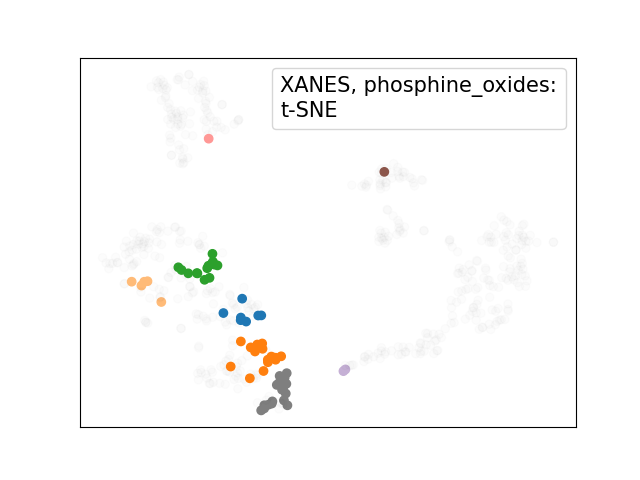

<IPython.core.display.Javascript object>


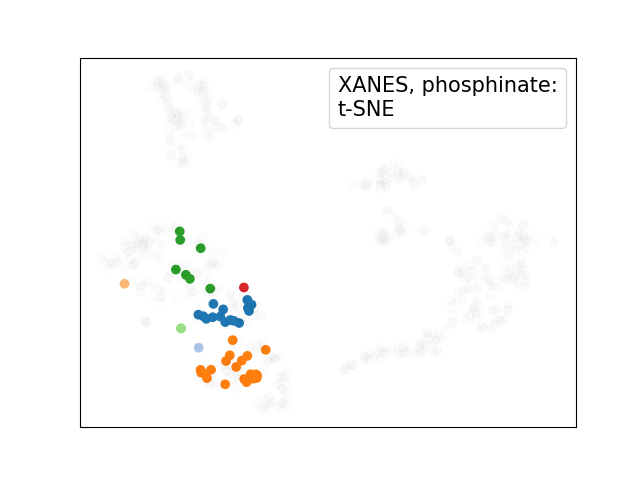

<IPython.core.display.Javascript object>


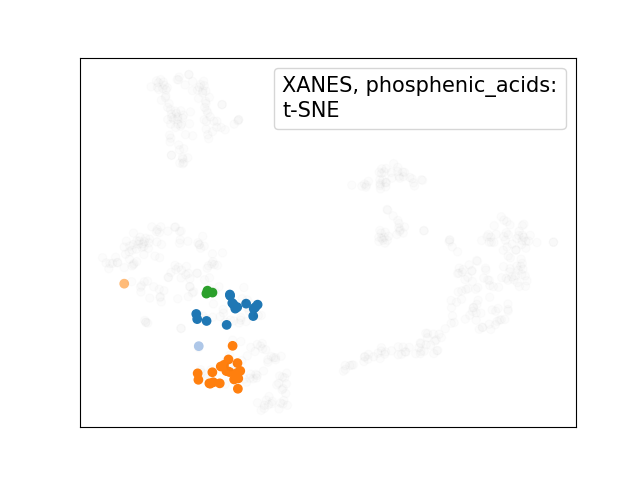

<IPython.core.display.Javascript object>


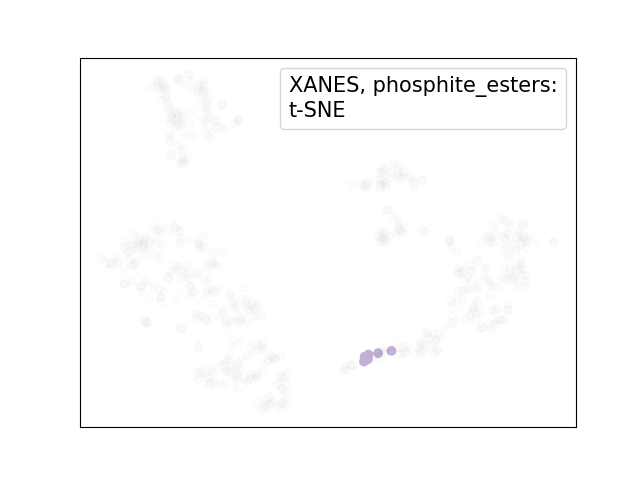

<IPython.core.display.Javascript object>


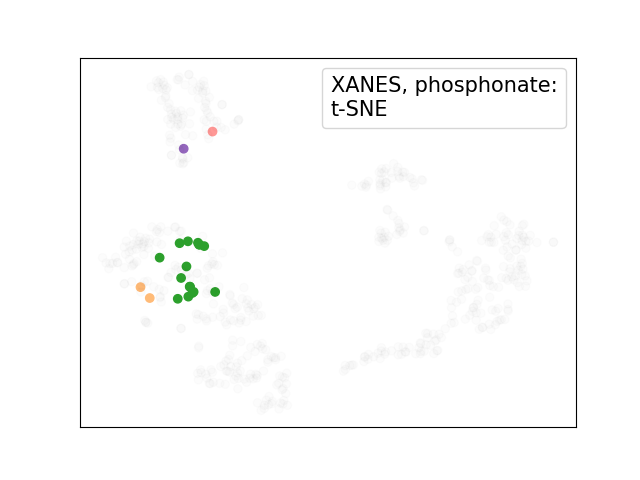

<IPython.core.display.Javascript object>


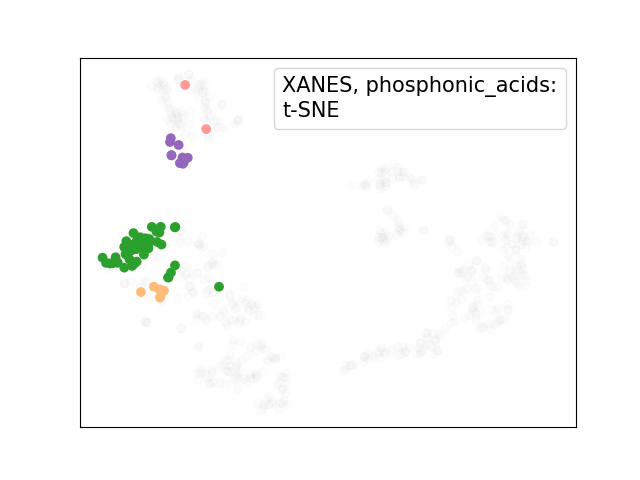

<IPython.core.display.Javascript object>


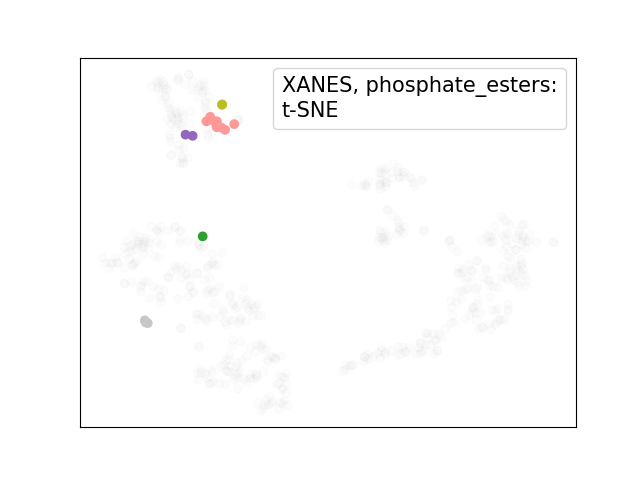

In [27]:
for t in typecodes:
    hidecids = [c['CID'] for c in XANES_data if c['Type']!=t]
    plot = u.plot_dim_red(plt.subplots(), XANES_data, XANES_tsnemap, colormap=XANES_clustermap, hiddencids=hidecids, mode=f'XANES, {t}', fontsize=15)
    u.add_pubchem_link(plot, XANES_data)
    u.add_label(plot, XANES_data, XANES_clustermap)

## Group Isolated Spaghetti Plots

<IPython.core.display.Javascript object>


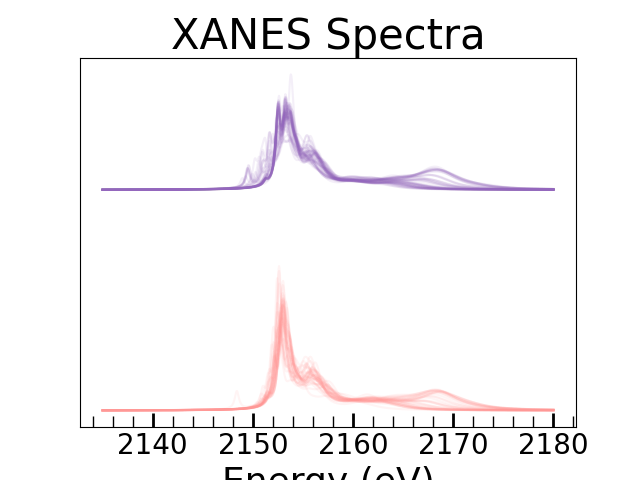

In [28]:
allowedclusters = (7,8)
isolated_XANES_data = [c for c in XANES_data if XANES_clustermap[c['CID']] in allowedclusters]
u.plot_spaghetti(plt.subplots(), isolated_XANES_data, binmap=XANES_clustermap, colormap=XANES_clustermap, mode='XANES', coloralpha=0.1);

<IPython.core.display.Javascript object>


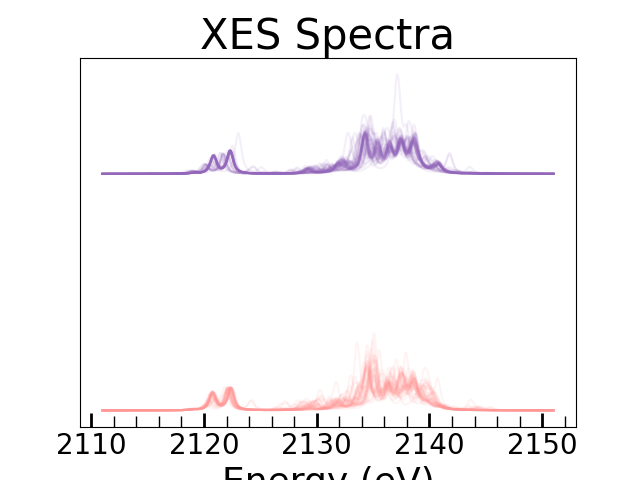

In [29]:
allowedclusters = (7,8)
isolated_XES_data = [c for c in XES_data if XANES_clustermap[c['CID']] in allowedclusters]
u.plot_spaghetti(plt.subplots(), isolated_XES_data, binmap=XANES_clustermap, colormap=XANES_clustermap, mode='XES', coloralpha=0.1);